In [52]:
!pip install -q librosa

In [261]:
from dataclasses import dataclass
from pathlib import Path
from IPython.display import Audio, Image
from typing import Union

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torchaudio
from skimage.restoration import denoise_wavelet, estimate_sigma
from scipy.signal import butter, lfilter, freqz

In [54]:
WAV_DATA_PATH = Path('/mnt/store/data/assets/black-grouper/data/mote-usb/wav-training-samples_3s-lpf')
TRAINING_DATA_PATH = Path('/mnt/store/data/assets/black-grouper/data/mote-usb/training-samples_1s-256fft-mean-db/wav-training-samples')

# Load wav files that were low-pass filtered at 700 Hz

In [55]:
call_nums = [
    0,  # Empty
    1,
    2,
    3,
    4,
    5,
    6,
    9,
    10,
    17,
    18,
    19,
    25,
    27,
    28,
    29,
    30,
    33,
    34,
    35,
    36
]
base_wav_path = {
    call: (WAV_DATA_PATH / f'call-{call}').glob('**/*.wav')
    for call
    in call_nums
}

In [56]:
# Summary of call types
for call_num in call_nums:
    try:
        y, sr = librosa.load(next(base_wav_path[call_num]))
        print(f'Call type: {call_num}, Recording Hz: {sr}')
    except StopIteration:
        print(f'0 calls for call type: {call_num}')

0 calls for call type: 0
Call type: 1, Recording Hz: 22050
Call type: 2, Recording Hz: 22050
Call type: 3, Recording Hz: 22050
Call type: 4, Recording Hz: 22050
Call type: 5, Recording Hz: 22050
Call type: 6, Recording Hz: 22050
Call type: 9, Recording Hz: 22050
Call type: 10, Recording Hz: 22050
Call type: 17, Recording Hz: 22050
Call type: 18, Recording Hz: 22050
Call type: 19, Recording Hz: 22050
Call type: 25, Recording Hz: 22050
0 calls for call type: 27
Call type: 28, Recording Hz: 22050
0 calls for call type: 29
0 calls for call type: 30
0 calls for call type: 33
0 calls for call type: 34
0 calls for call type: 35
0 calls for call type: 36


In [62]:
def load_wav(fpath):
    y, sr = librosa.load(fpath)
    audio, _ = librosa.effects.trim(y)
    
    return audio

def plot_wav(fpath):
    audio = load_wav(fpath)
    
    plt.figure(figsize=(10, 8))
    librosa.display.waveshow(y=audio, sr=sr)
    
    plt.title(f'Sample {fpath}')

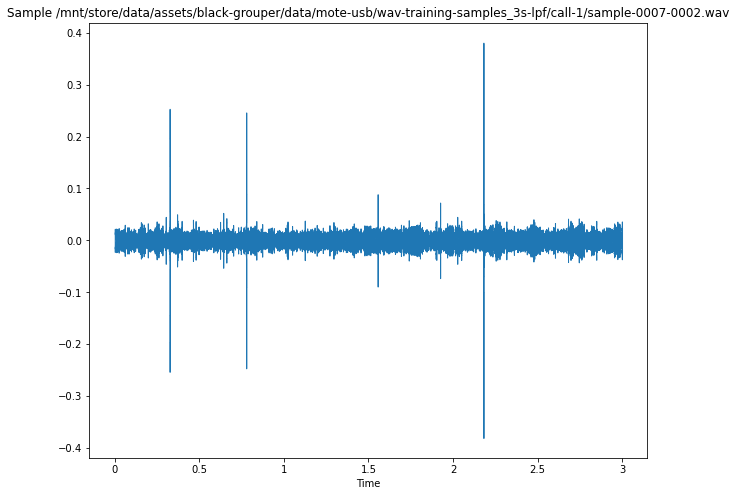

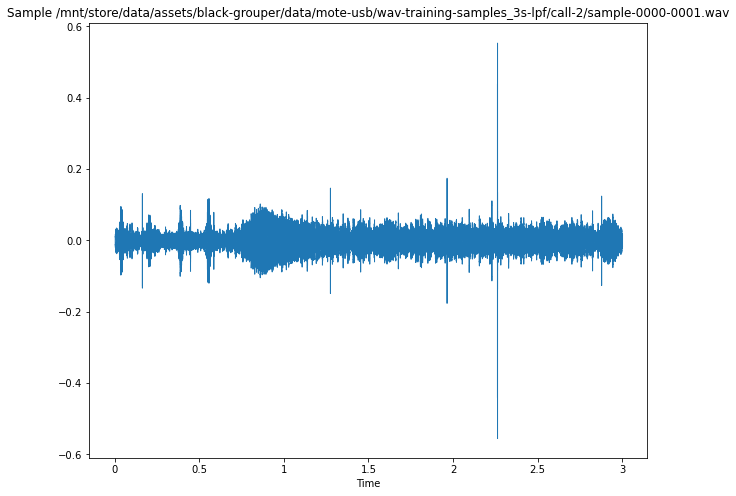

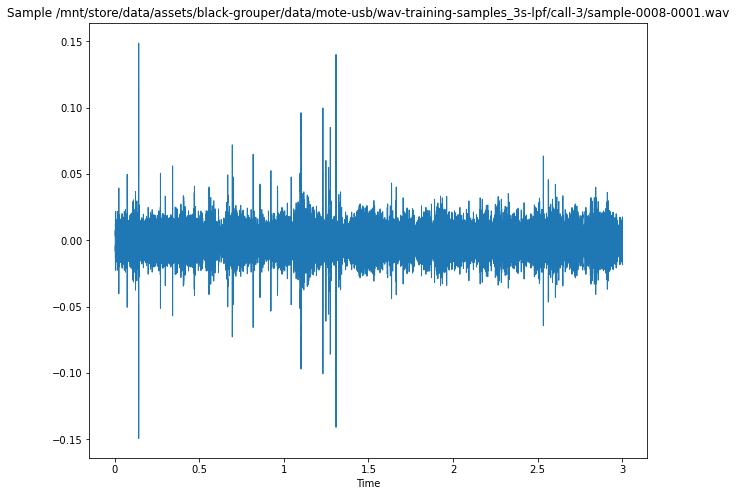

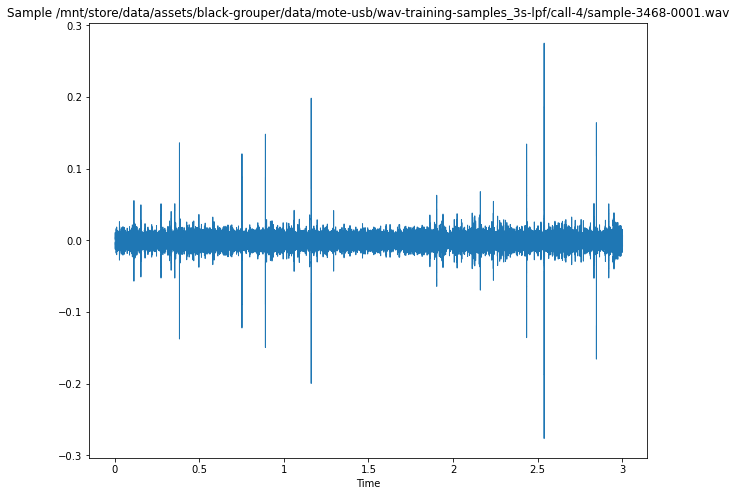

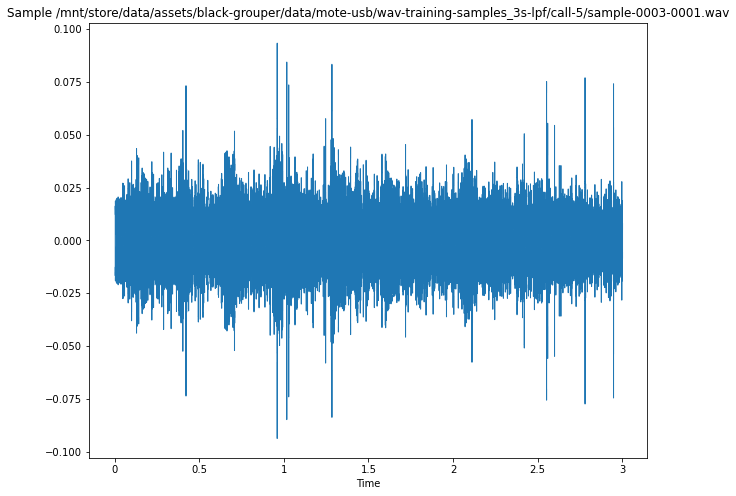

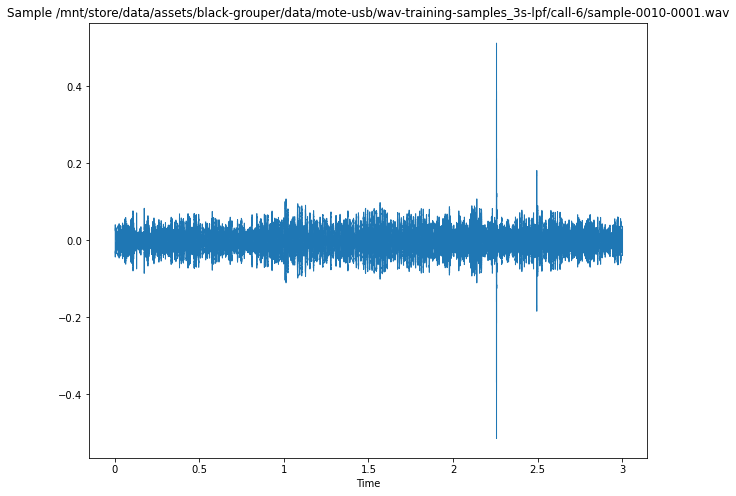

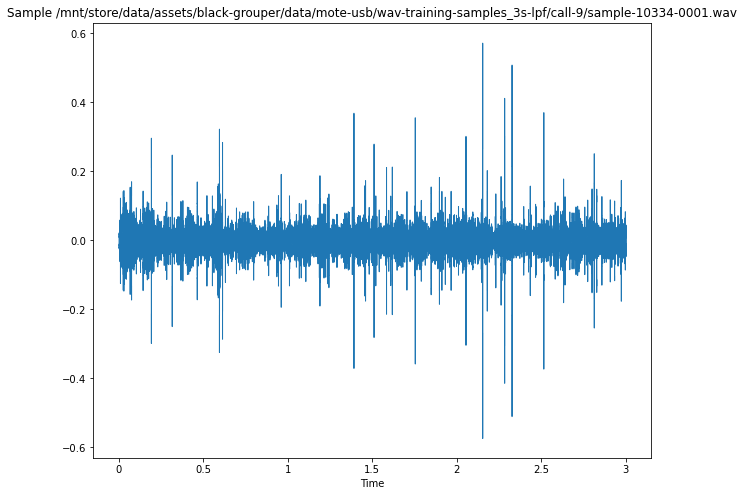

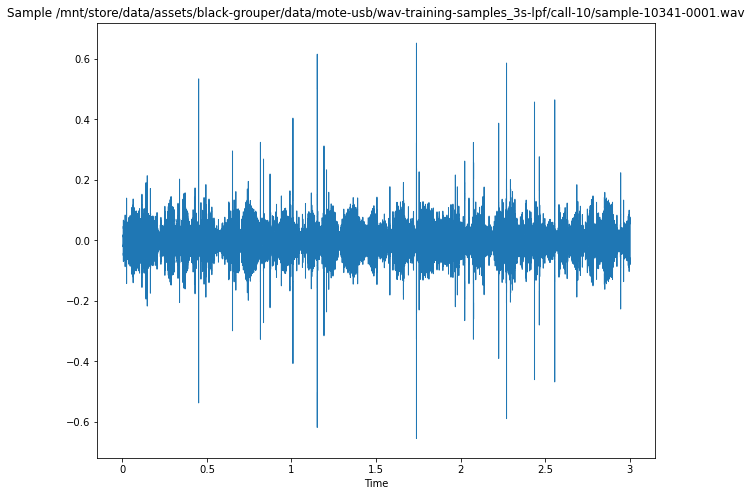

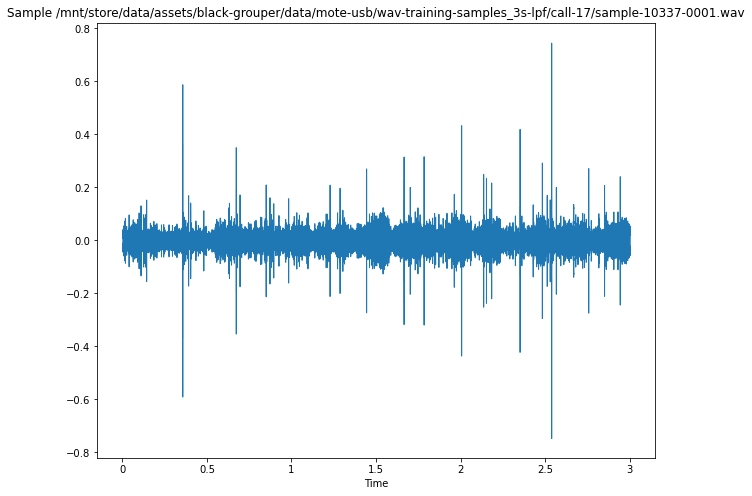

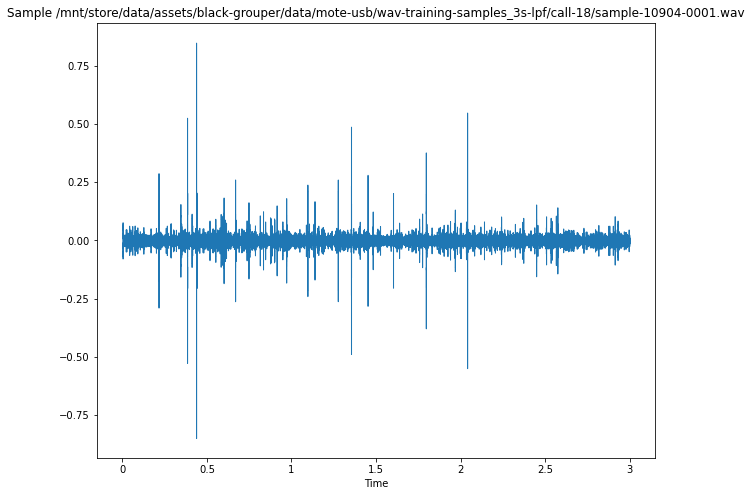

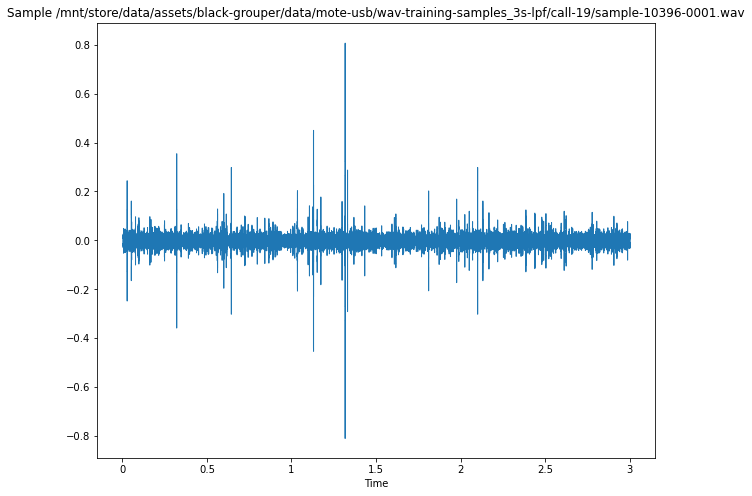

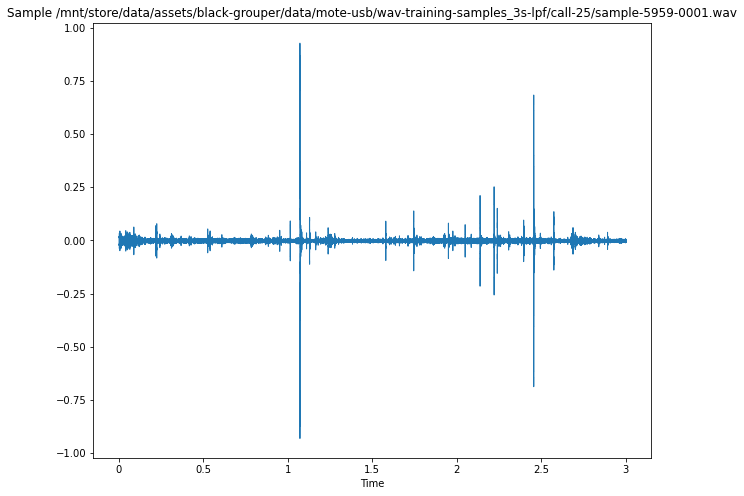

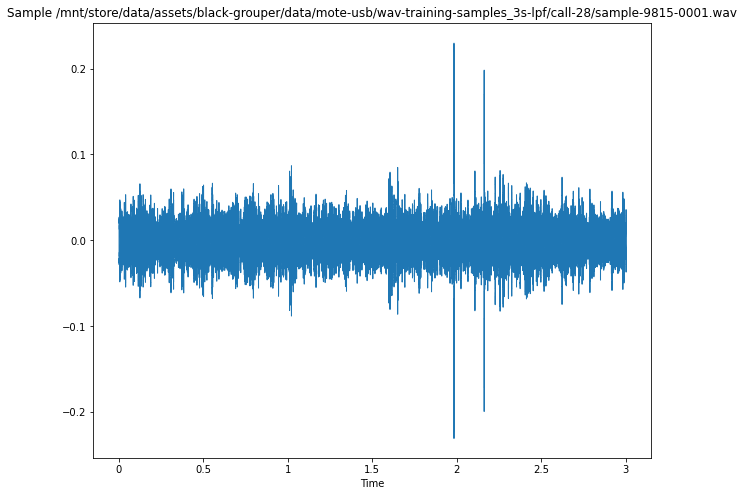

In [63]:
for call_num in call_nums:
    try:
        plot_wav(next(base_spec_path[call_num]))
    except StopIteration:
        continue

## Dev spectrograms

In [275]:
@dataclass
class FFTConfig():
    n_fft: Union[int, None] = 1024
    hop_length: int = 512
    sr: int = 22_050
    db: bool = False
    mel: bool = False
    fmin: int = 50
    fmax: int = 10_000
    y_axis: str = 'linear'
    denoise: Union[str, None] = None
    pcen: bool = False

In [276]:
base_config = FFTConfig()

In [277]:
def calc_stft(audio, fft_config):
    stft = librosa.stft(audio, n_fft=fft_config.n_fft, hop_length=fft_config.hop_length)
    return np.abs(stft)

In [278]:
wav_sample_01 = load_wav(next(base_wav_path[1]))

### Examine effect of hop length on freq rep

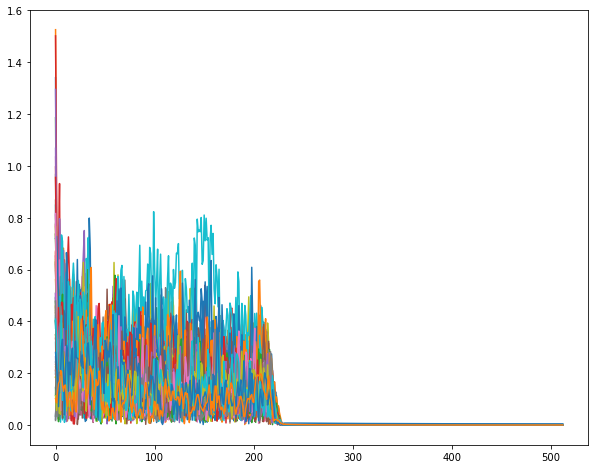

In [279]:
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, base_config));

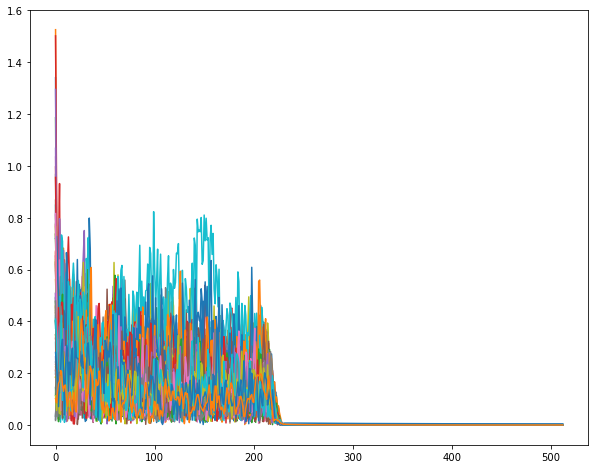

In [280]:
config = FFTConfig(1024, 512)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

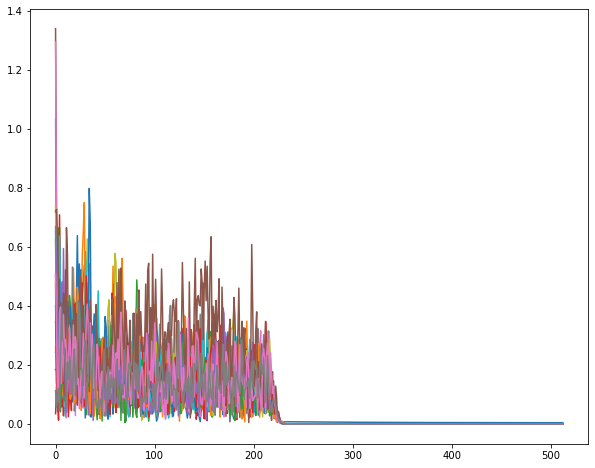

In [281]:
config = FFTConfig(1024, 2048)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

### Examine number of FFTs on freq rep

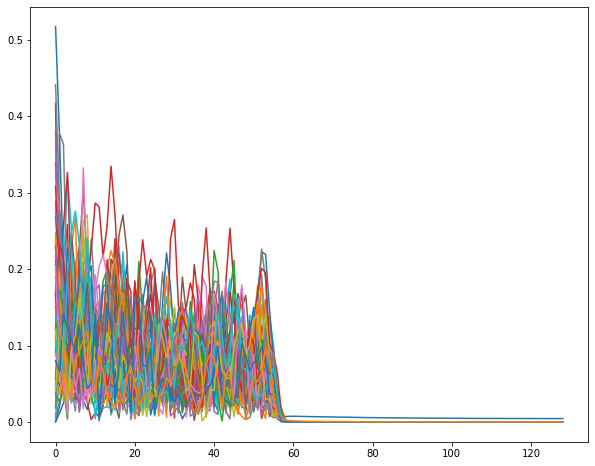

In [282]:
config = FFTConfig(256, 512)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

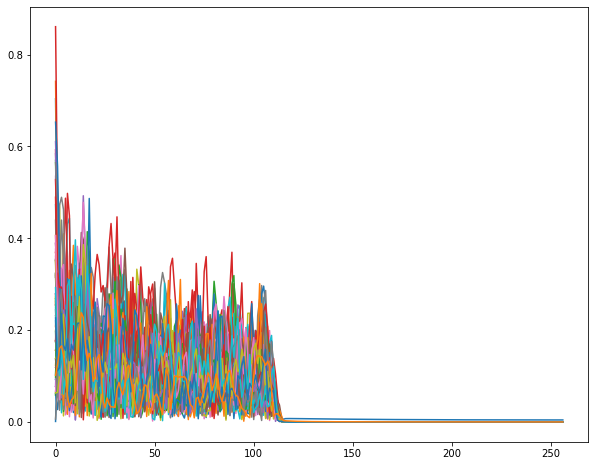

In [283]:
config = FFTConfig(512, 512)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

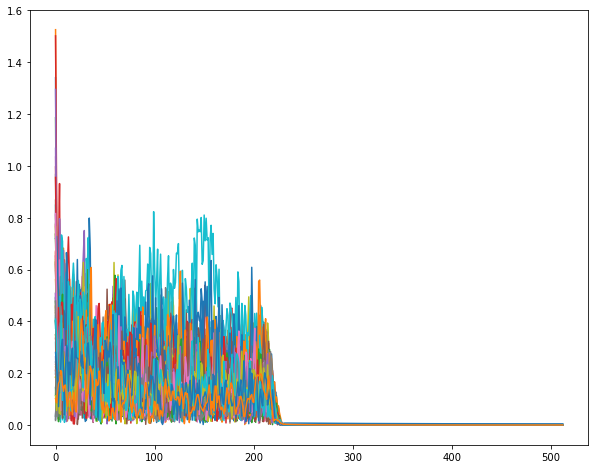

In [284]:
config = FFTConfig(1024, 512)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

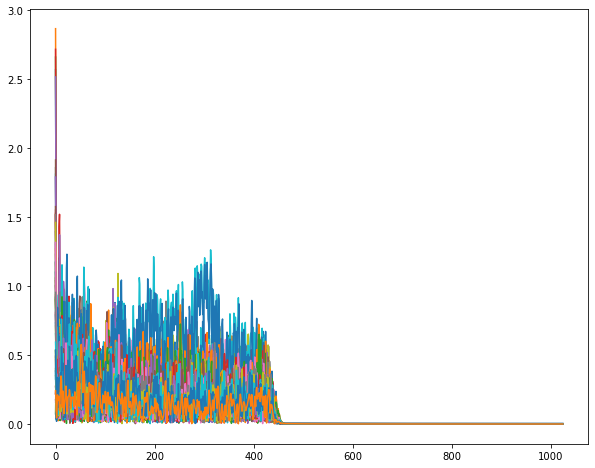

In [285]:
config = FFTConfig(2048, 512)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

### Explore spectrograms

Compare:

    - db vs. linear
    - effects of hoplength + nffts
    - mel vs. "normal"

In [302]:
def plot_spec(audio, fft_config):
    stft = calc_stft(audio, fft_config)
    
    if fft_config.pcen:
        sftf = librosa.pcen(stft, sr=fft_config.sr, hop_length=fft_config.hop_length)
        fft_config.db = True
    
    if fft_config.mel:
        stft = librosa.feature.melspectrogram(y=audio, sr=fft_config.sr)
        # Mel is in db
        fft_config.db = True
    
    if fft_config.db:
        stft = librosa.amplitude_to_db(stft, ref=np.max)
        
    plt.figure(figsize=(10, 8))
    librosa.display.specshow(
        stft,
        sr=fft_config.sr,
        hop_length=fft_config.hop_length,
        x_axis='time',
        y_axis=fft_config.y_axis,
        fmin=fft_config.fmin,
        fmax=fft_config.fmax
    )
    plt.title(f'{fft_config}')

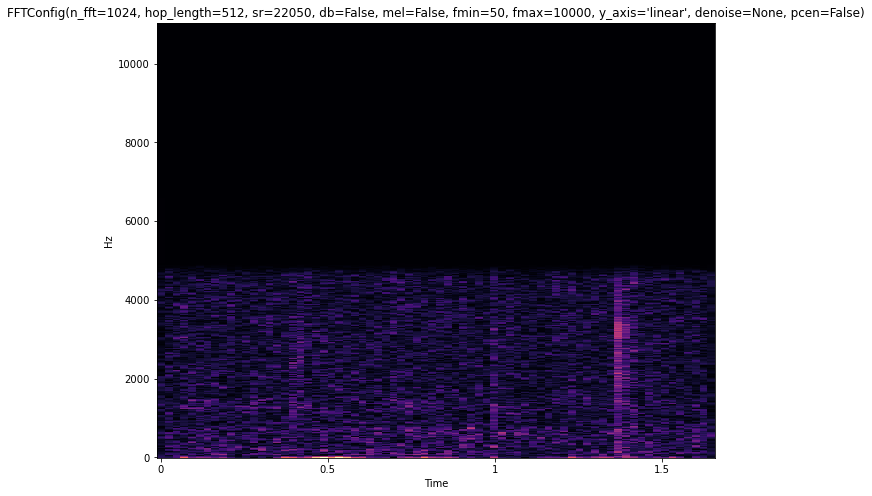

In [303]:
plot_spec(wav_sample_01, base_config)

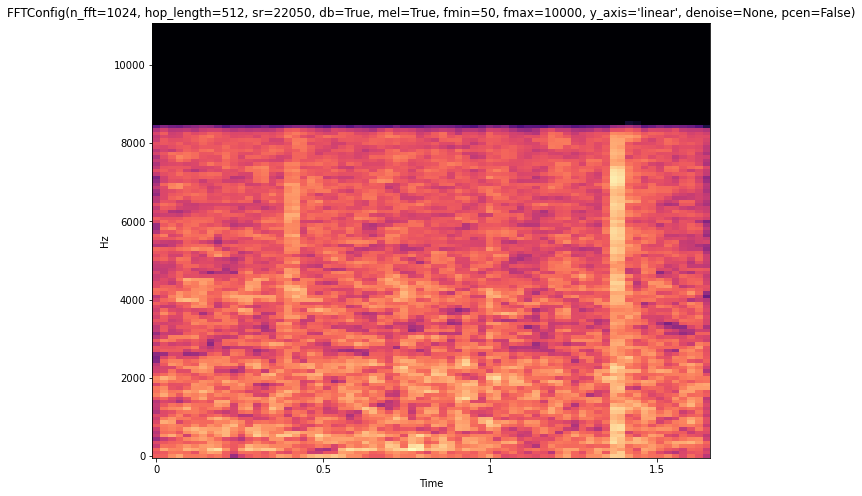

In [304]:
config = FFTConfig(
    mel=True
)
plot_spec(wav_sample_01, config)

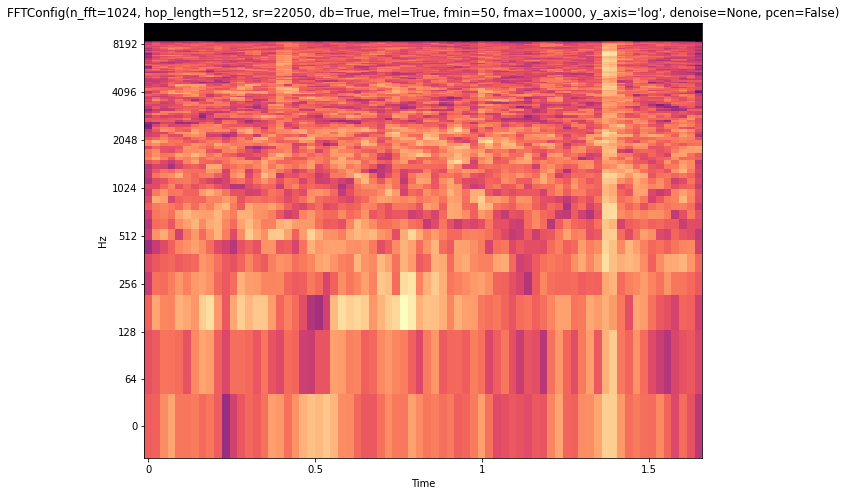

In [305]:
config = FFTConfig(
    mel=True,
    y_axis='log'
)
plot_spec(wav_sample_01, config)

FFTConfig(n_fft=1024, hop_length=512, sr=22050, db=False, mel=True, fmin=50, fmax=10000, y_axis='linear', denoise=None, pcen=False)


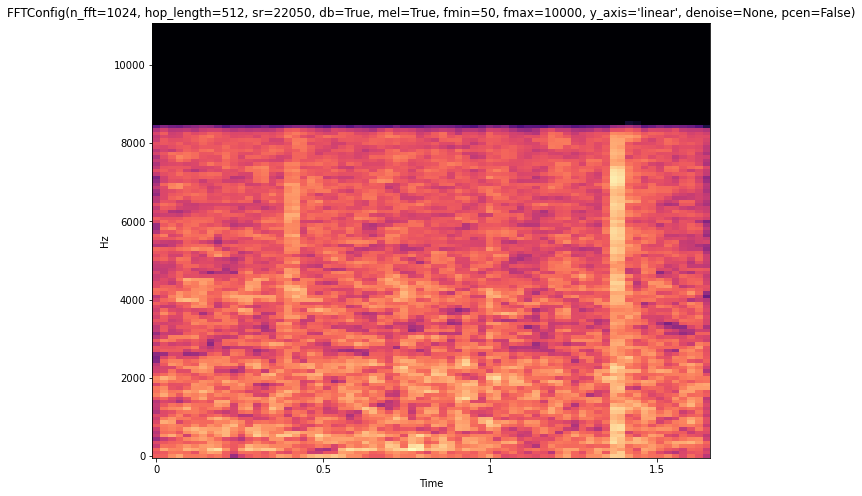

In [306]:
config = FFTConfig(
    mel=True,
)
print(config)
plot_spec(wav_sample_01, config)

FFTConfig(n_fft=256, hop_length=512, sr=22050, db=False, mel=True, fmin=50, fmax=10000, y_axis='linear', denoise=None, pcen=False)


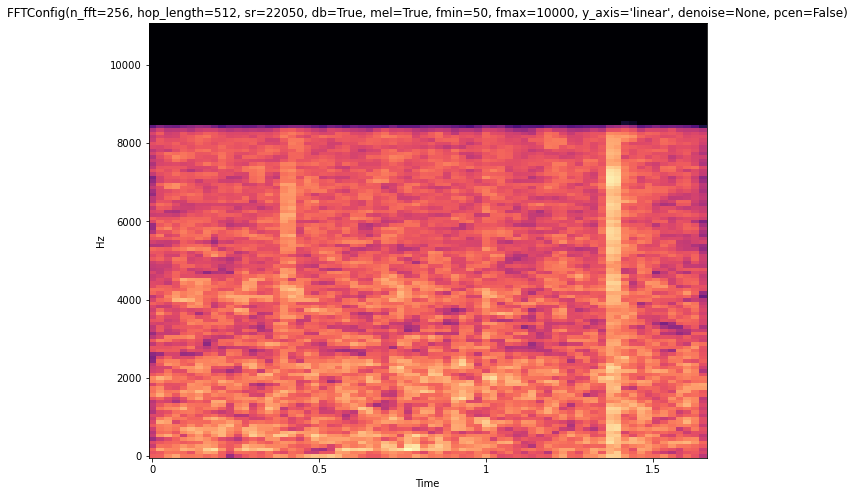

In [307]:
config = FFTConfig(
    n_fft=256,
    mel=True,
    hop_length=512,
)
print(config)
plot_spec(wav_sample_01, config)

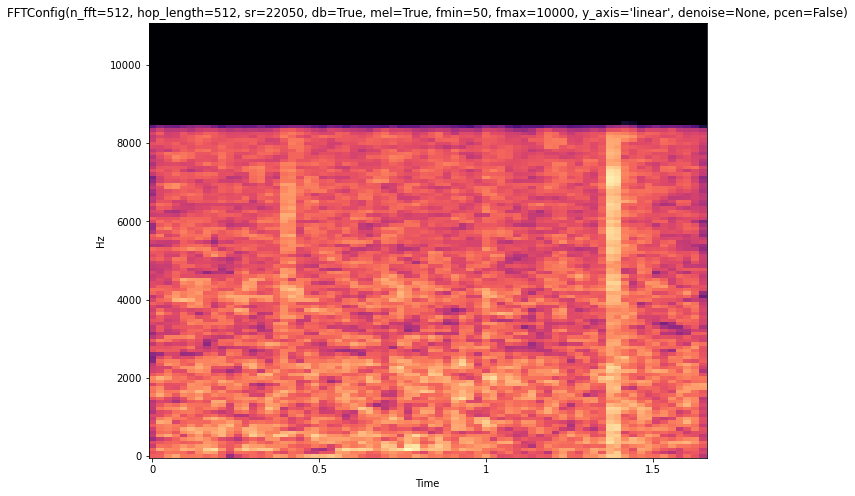

In [308]:
config = FFTConfig(
    n_fft=512,
    mel=True,
    hop_length=512,
)
plot_spec(wav_sample_01, config)

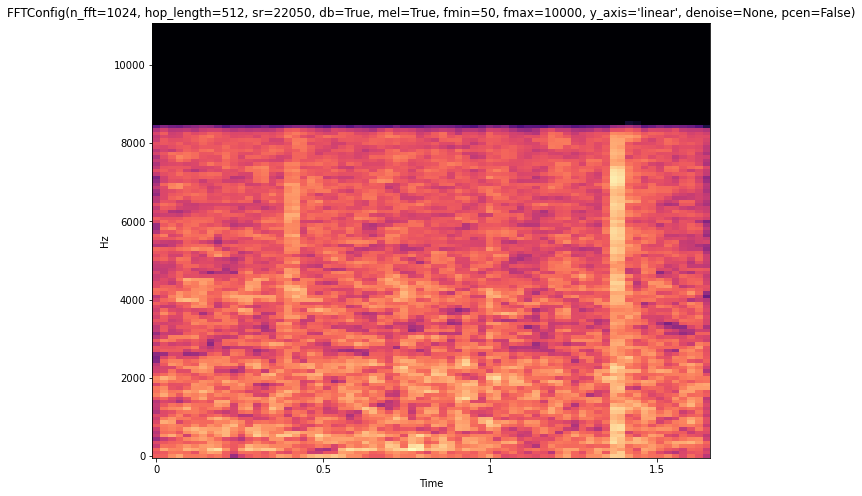

In [309]:
config = FFTConfig(
    n_fft=1024,
    mel=True,
    hop_length=512,
)
plot_spec(wav_sample_01, config)

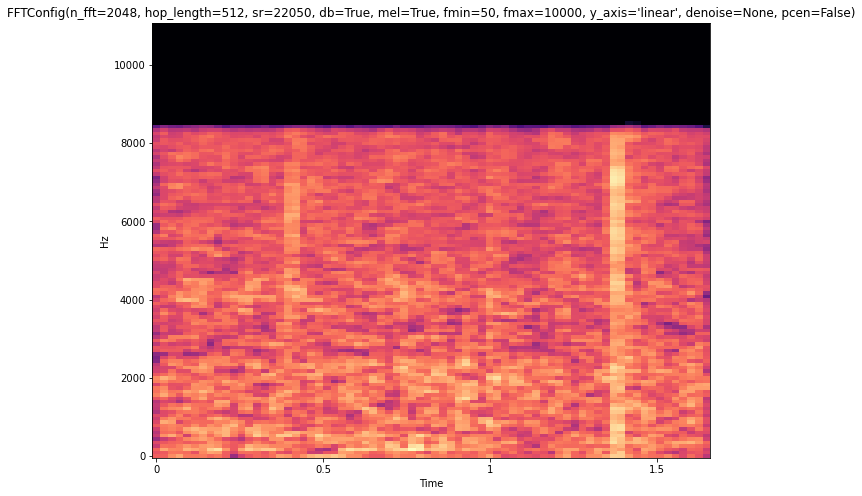

In [310]:
config = FFTConfig(
    n_fft=2048,
    mel=True,
    hop_length=512,
)
plot_spec(wav_sample_01, config)

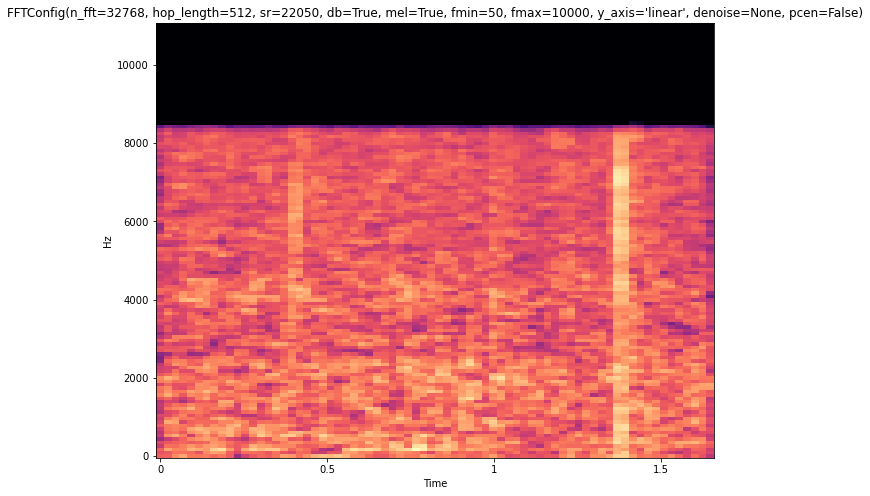

In [311]:
config = FFTConfig(
    n_fft=2**15,
    mel=True,
    hop_length=512,
)
plot_spec(wav_sample_01, config)

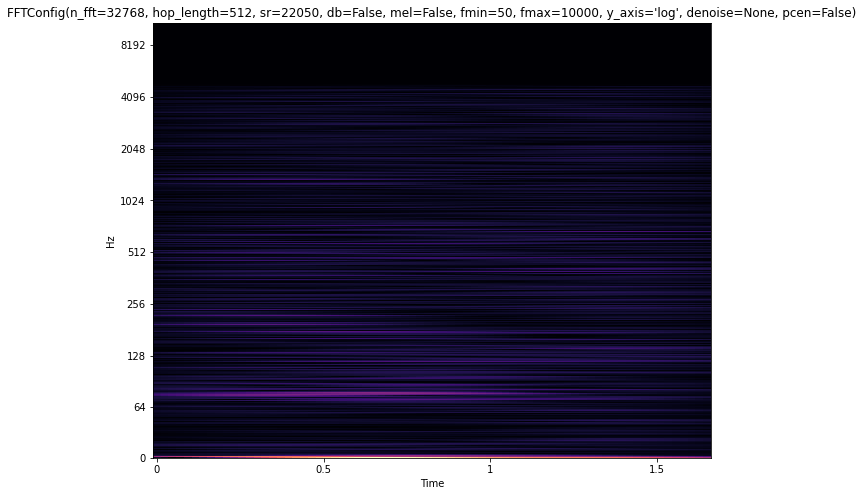

In [312]:
config = FFTConfig(
    n_fft=2**15,
    mel=False,
    hop_length=512,
    y_axis='log'
)
plot_spec(wav_sample_01, config)

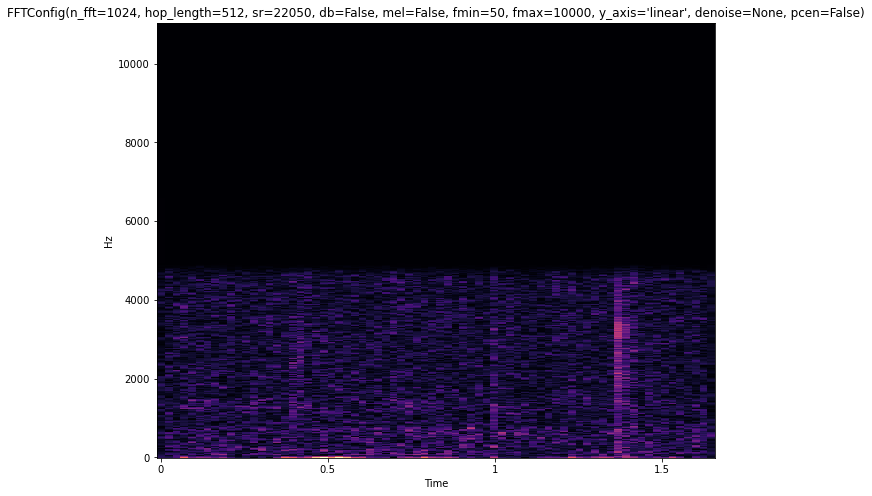

In [313]:
plot_spec(wav_sample_01, base_config)

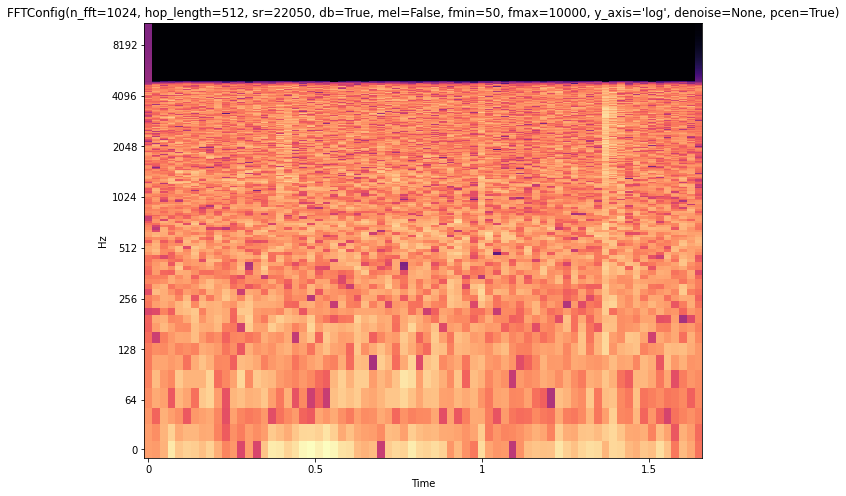

In [314]:
config = FFTConfig(
    n_fft=1024,
    mel=False,
    hop_length=512,
    y_axis='log',
    pcen=True
)
plot_spec(wav_sample_01, config)

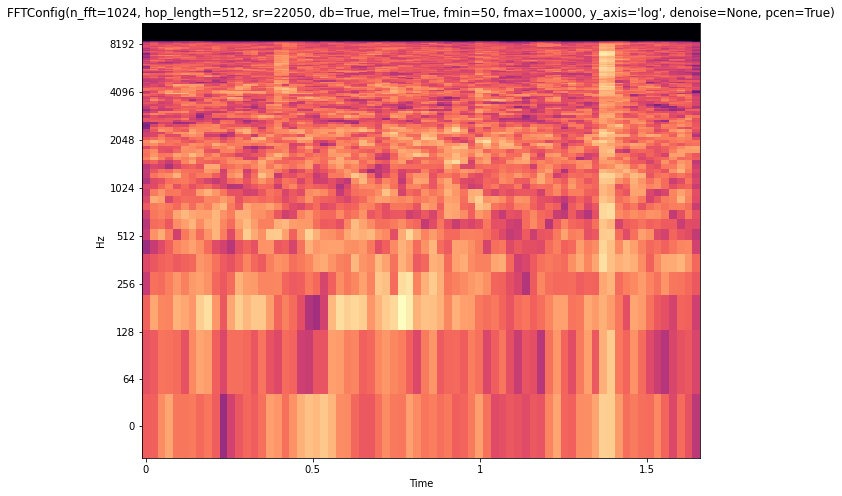

In [315]:
config = FFTConfig(
    n_fft=1024,
    mel=True,
    hop_length=512,
    y_axis='log',
    pcen=True
)
plot_spec(wav_sample_01, config)

In [260]:
Audio(wav_sample_01, rate=22_050)

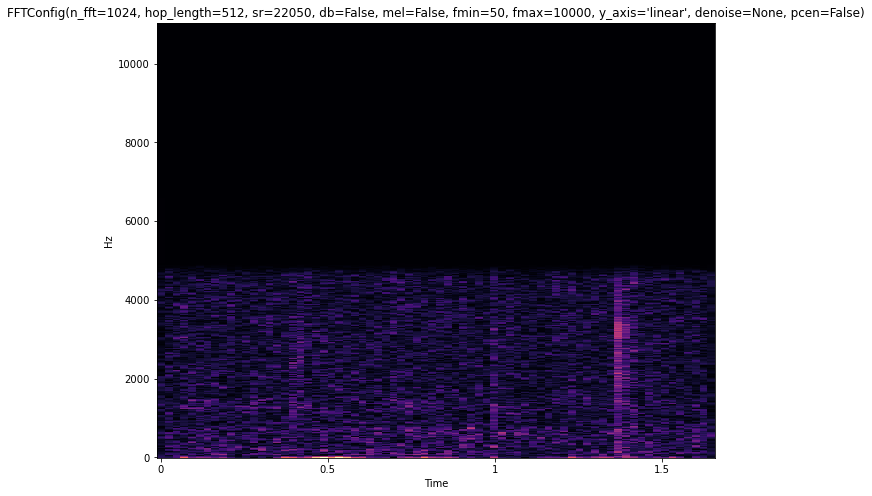

In [316]:
plot_spec(wav_sample_01, base_config)

### Idea.

Turn creation of spectrograms into an optimization problem where the distance
between clusters is maximized.